# Paper figures
This notebook provides the code for generating the figures of our paper.

In [1]:
import numpy as np
#import pandas as pd

from ddm import Model, Drift, InitialCondition
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision
from ddm.functions import fit_adjust_model

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

## 1. nlDDM formalism

In [ ]:
#plot the resulting potential functions for a given a
def potential(x,z,a,k):
    '''the potential function is defined as minus the integral on x of the differential equation'''
    return k/4*x**4-k*z/3*x**3-k*a**2/2*x**2+k*z*a**2*x

Potential function when $z$ varies

<IPython.core.display.Javascript object>


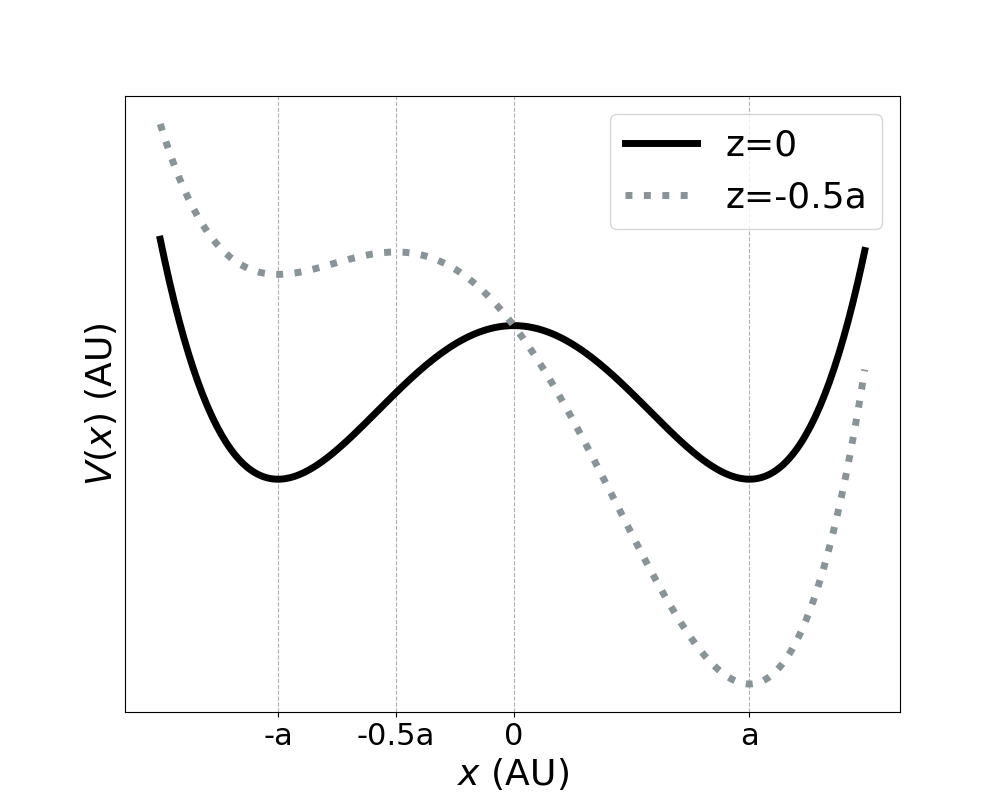

In [2]:
xtemp=np.arange(-1.5,1.5, 0.01)
ztemp=[0,-0.5]
a=1
k=1
plt.figure(figsize=(10,8))
plt.plot(xtemp,potential(xtemp,ztemp[0],a,k),'k',label='z=0', linewidth=5)
plt.plot(xtemp,potential(xtemp,ztemp[1],a,k),'#899499',label='z=-0.5a', linestyle=':',linewidth=5)#nice shade but too light:'#a4e5d3'
plt.ylabel('$V(x)$ (AU)',fontsize=26)
plt.xlabel('$x$ (AU)',fontsize=26)
plt.xticks(ticks=[-1,-0.5,0,1], labels=["-a","-0.5a","0","a"],fontsize=22)
plt.yticks(ticks=[],fontsize=22)
plt.grid(linestyle='--')
plt.legend(fontsize=26)
plt.title('Potential function of the model depending on z',fontsize=20)

Potential function when $a$ varies

<IPython.core.display.Javascript object>


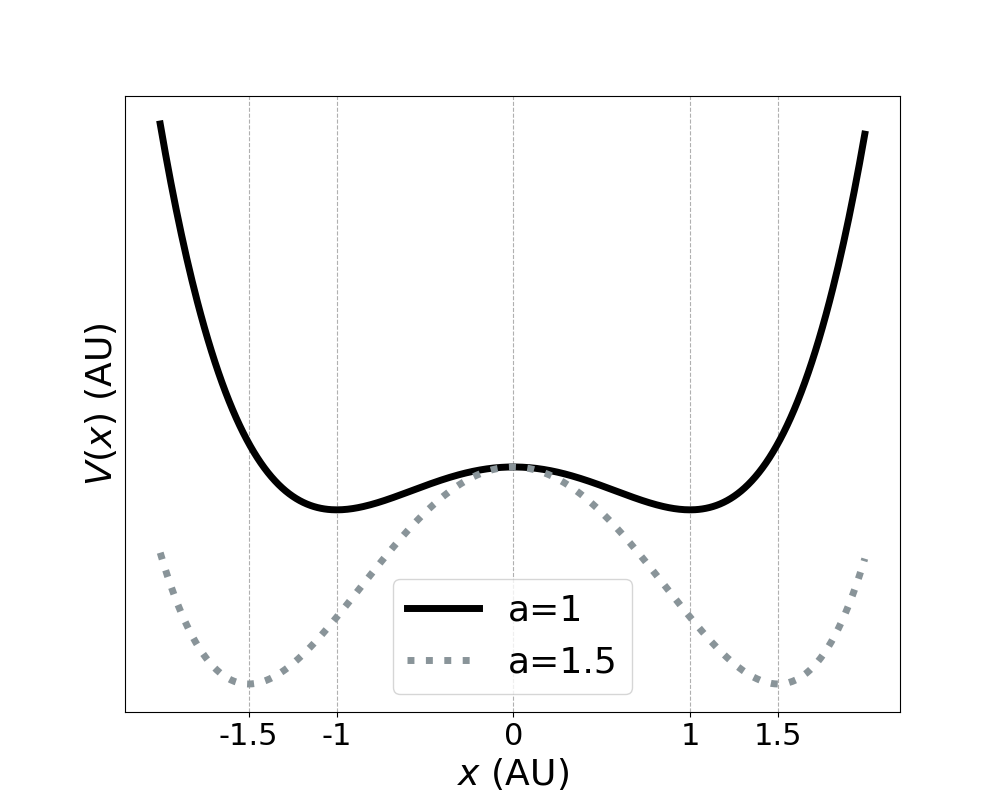

In [3]:
xtemp=np.arange(-2,2, 0.01)
z=0
atemp=[1,1.5]
k=1
plt.figure(figsize=(10,8))
plt.plot(xtemp,potential(xtemp,z,atemp[0],k),'k',label='a=1', linewidth=5)
plt.plot(xtemp,potential(xtemp,z,atemp[1],k),'#899499',label='a=1.5', linestyle=':',linewidth=5)
plt.ylabel('$V(x)$ (AU)',fontsize=26)
plt.xlabel('$x$ (AU)',fontsize=26)
plt.xticks(ticks=[-1.5,-1,0,1,1.5], labels=["-1.5","-1","0","1","1.5"],fontsize=22)
plt.yticks(ticks=[],fontsize=22)
plt.grid(linestyle='--')
plt.legend(fontsize=26)
plt.title('Potential function of the model depending on a',fontsize=20)

Potential function when $k$ varies

<IPython.core.display.Javascript object>


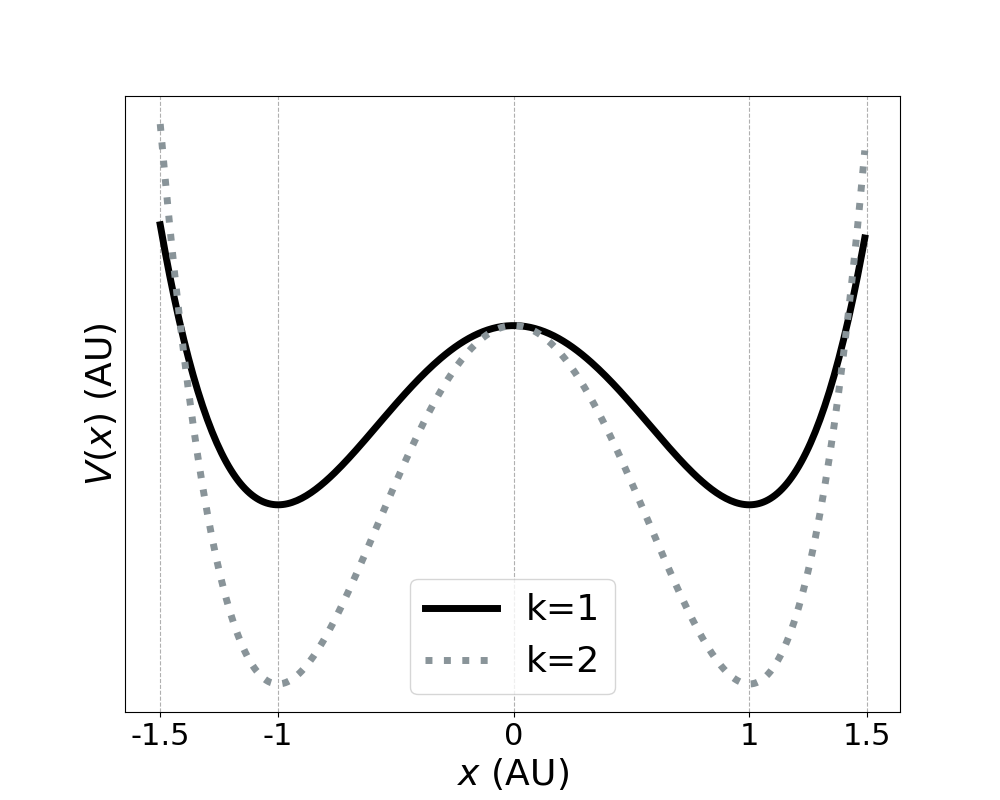

In [4]:
xtemp=np.arange(-1.5,1.5, 0.01)
z=0
a=1
ktemp=[1,2]
plt.figure(figsize=(10,8))
plt.plot(xtemp,potential(xtemp,z,a,ktemp[0]),'k',label='k=1', linewidth=5)
plt.plot(xtemp,potential(xtemp,z,a,ktemp[1]),'#899499',label='k=2', linestyle=':',linewidth=5)
plt.ylabel('$V(x)$ (AU)',fontsize=26)
plt.xlabel('$x$ (AU)',fontsize=26)
plt.xticks(ticks=[-1.5,-1,0,1,1.5], labels=["-1.5","-1","0","1","1.5"],fontsize=22)
plt.yticks(ticks=[],fontsize=22)
plt.grid(linestyle='--')
plt.legend(fontsize=26)
plt.title('Potential function of the model depending on k',fontsize=20)

These are what the noiseless trajectories look like in the nl-DDM case, for different values of the initial condition $x_0$

<IPython.core.display.Javascript object>


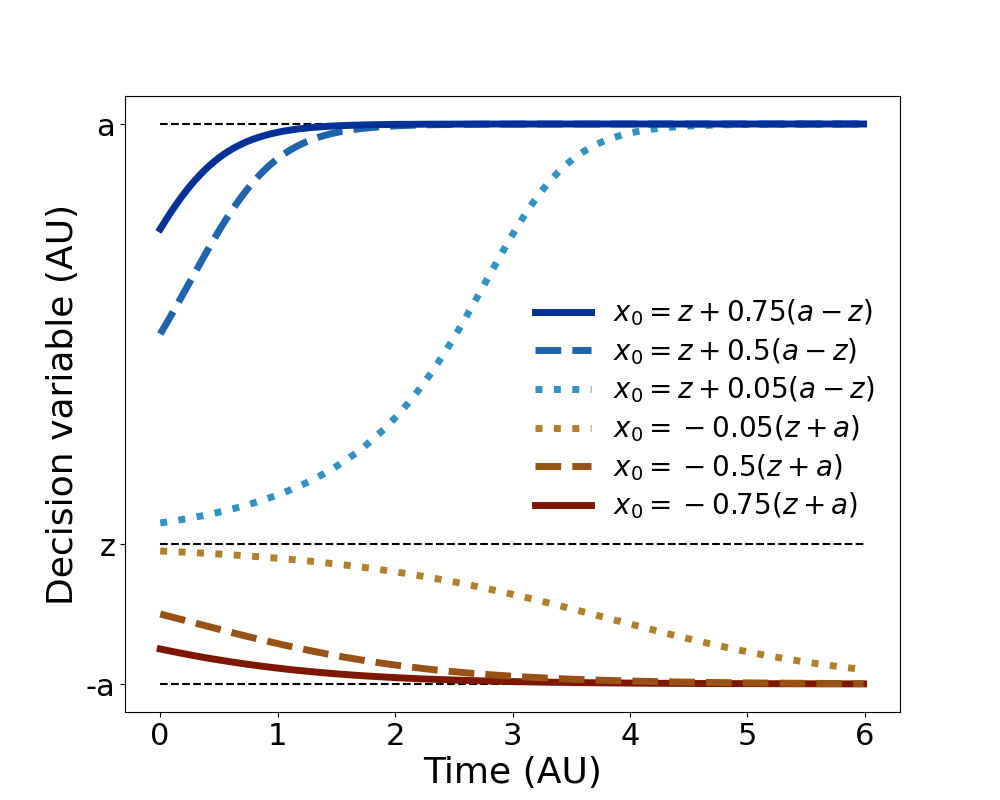

0
1
2
3
4
5


In [5]:
#here, generate some trajectories. Need Euler Mayurama
def EM(xfun,nfun,x0,t,a,k,z,s=0):
    x=np.zeros(len(t))
    dt=t[1]-t[0]
    x[0]=x0
    for i in range (1,t.size):
        Wt=np.random.normal(loc=0.0, scale=np.sqrt(dt))
        x[i]=x[i-1]+xfun(x[i-1],a,k,z)*dt+nfun(x[i-1],s)*Wt
    return x

def gfun(x,s):
    return s

def adm(x,a,k,z):
    return -k*(x-z)*(x-a)*(x+a)

a=1
k=1
z=-0.5
dt=0.01
t=np.arange(0,6,dt)
x0s=[-0.75*0.5-0.5,-0.5-0.25, -0.5-0.05*0.5,-0.5+1.5*0.05,-0.5+1.5*0.5,-0.5+1.5*0.75]
ntrials=len(x0s)

trajectories=np.zeros((ntrials,len(t)))
for tr in range(ntrials):
    trajectories[tr,:]=EM(adm,gfun,x0s[tr],t,a,k,z)
    
linestyles=['solid','dashed','dotted','dotted','dashed','solid']
colors=['#7E1700','#995215','#B0802B','#3292C2','#2064AE','#033198']

plt.figure(figsize=(10,8))
for i in range (ntrials):
    plt.plot(t, trajectories[i,:],color=colors[i], linestyle=linestyles[i], linewidth=5)
plt.hlines(a,0,6, "k","--")
plt.hlines(-a,0,6, "k",'--')
plt.hlines(z,0,6, "k",'--')
plt.yticks(ticks=[-a,z,a], labels=["-a","z","a"],fontsize=22)
plt.xticks(fontsize=22)
plt.xlabel('Time (AU)', fontsize=26)
plt.ylabel('Decision variable (AU)', fontsize=26)
plt.legend([r'$x_0=-0.75(z+a)$',r'$x_0=-0.5(z+a)$',r'$x_0=-0.05(z+a)$',r'$x_0=z+0.05(a-z)$',r'$x_0=z+0.5(a-z)$',r'$x_0=z+0.75(a-z)$'], frameon=False, bbox_to_anchor=(1., 0.4),labelspacing=-2.5,fontsize=20)

plt.title('Noiseless trajectories under different initial conditions', fontsize=30)

In the paper, we described a way of defining the mean drift. Its advantage is that it does not depend on the duration of the trajectory

<IPython.core.display.Javascript object>


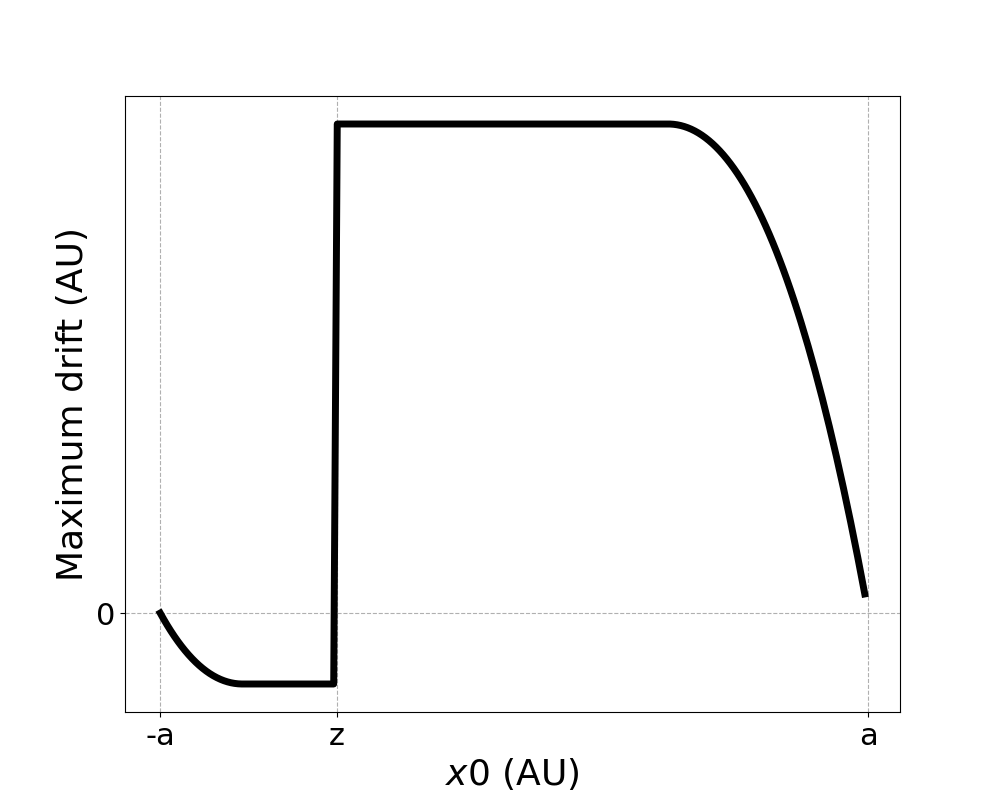

In [7]:
#here is another formula, this time using the max drift:
def x_max(a,k,z):
    xmin=1/3*(z-np.sqrt(z**2+3*a**2))
    xmax=1/3*(z+np.sqrt(z**2+3*a**2))
    return xmin, xmax

def max_drift(x0s,a,k,z):
    md=[]
    xmin,xmax=x_max(a,k,z)
    for x0 in x0s:
        if x0>xmax or x0<xmin:
            d=-k*(x0+a)*(x0-a)*(x0-a*z)
        elif x0<=z:
            d=-k*(xmin+a)*(xmin-a)*(xmin-a*z)
        else:
            d=d=-k*(xmax+a)*(xmax-a)*(xmax-a*z)
        md.append(d)
    return md
x0=np.arange(-a,a,0.01)

plt.figure(figsize=(10,8))
plt.plot(x0,max_drift(x0,1,1,-0.5),'k',linewidth=5)
plt.ylabel('Maximum drift (AU)',fontsize=26)
plt.xlabel('$x0$ (AU)',fontsize=26)
plt.xticks(ticks=[-a,z,a], labels=["-a","z","a"],fontsize=22)
plt.yticks(ticks=[0],fontsize=22)
plt.grid(linestyle='--')

With the previous definition, this is how the mean drift varies as a function of $a$ and $z$

<IPython.core.display.Javascript object>


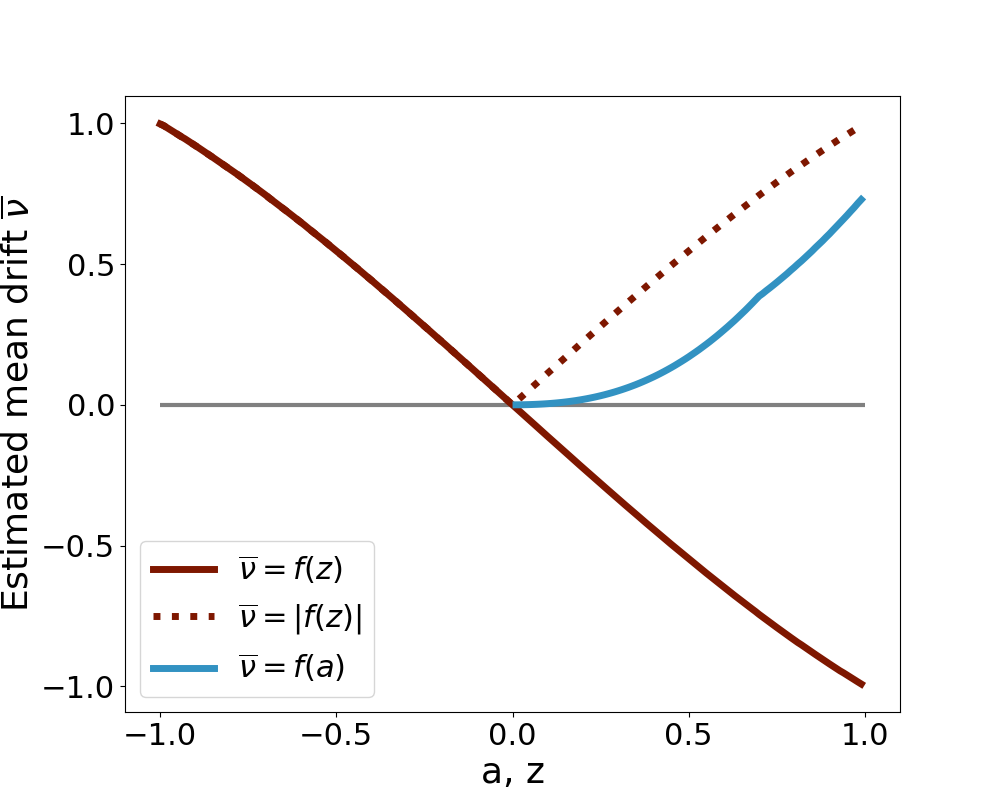

([<matplotlib.axis.XTick at 0x1bf5e998250>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [9]:
#here we plot the mean drift from the max estimate
def mean_max_drift(a,k,z):
    x0s=np.linspace(-a,a,1000)
    max_drifts=max_drift(x0s,a,k,z)
    xmin,xmax=x_max(a,k,z)
    for i in range(len(x0s)):
        if x0s[i]<xmin:
            max_drifts[i]/=(xmin+a)
        elif x0s[i]<z:
            max_drifts[i]/=(z-xmin)
        elif x0s[i]<xmax:
            max_drifts[i]/=(xmax-z)
        else:
            max_drifts[i]/=(a-xmax)
    return np.mean(max_drifts)


zs=np.arange(-1,1,0.01)
a=1
k=1
drifts_z=[]
for z in zs:
    drifts_z.append(mean_max_drift(a,k,z))
z=-0.7
a_s=np.arange(0.01,1,0.01)
drifts_a=[]
for a in a_s:
    drifts_a.append(mean_max_drift(a,k,z))
plt.figure(figsize=(10,8))
plt.plot(zs,drifts_z, '#7E1700', linewidth=5, label=r'$\overline{\nu}=f(z)$')
plt.plot(zs, np.abs(drifts_z), '#7E1700', linewidth=5, linestyle="dotted", label=r'$\overline{\nu}=|f(z)|$')
plt.plot(a_s, drifts_a, '#3292C2', linewidth=5, label=r'$\overline{\nu}=f(a)$')
plt.hlines(0,1,-1, 'grey', linestyle='solid',linewidth=3)
plt.legend(fontsize=22)
plt.ylabel(r'Estimated mean drift $\overline{\nu}$',fontsize=26)
plt.xlabel('a, z', fontsize=26)
plt.yticks([-1,-0.5, 0,0.5,1],fontsize=22)
plt.xticks([-1,-0.5, 0,0.5,1], fontsize=22)

<IPython.core.display.Javascript object>


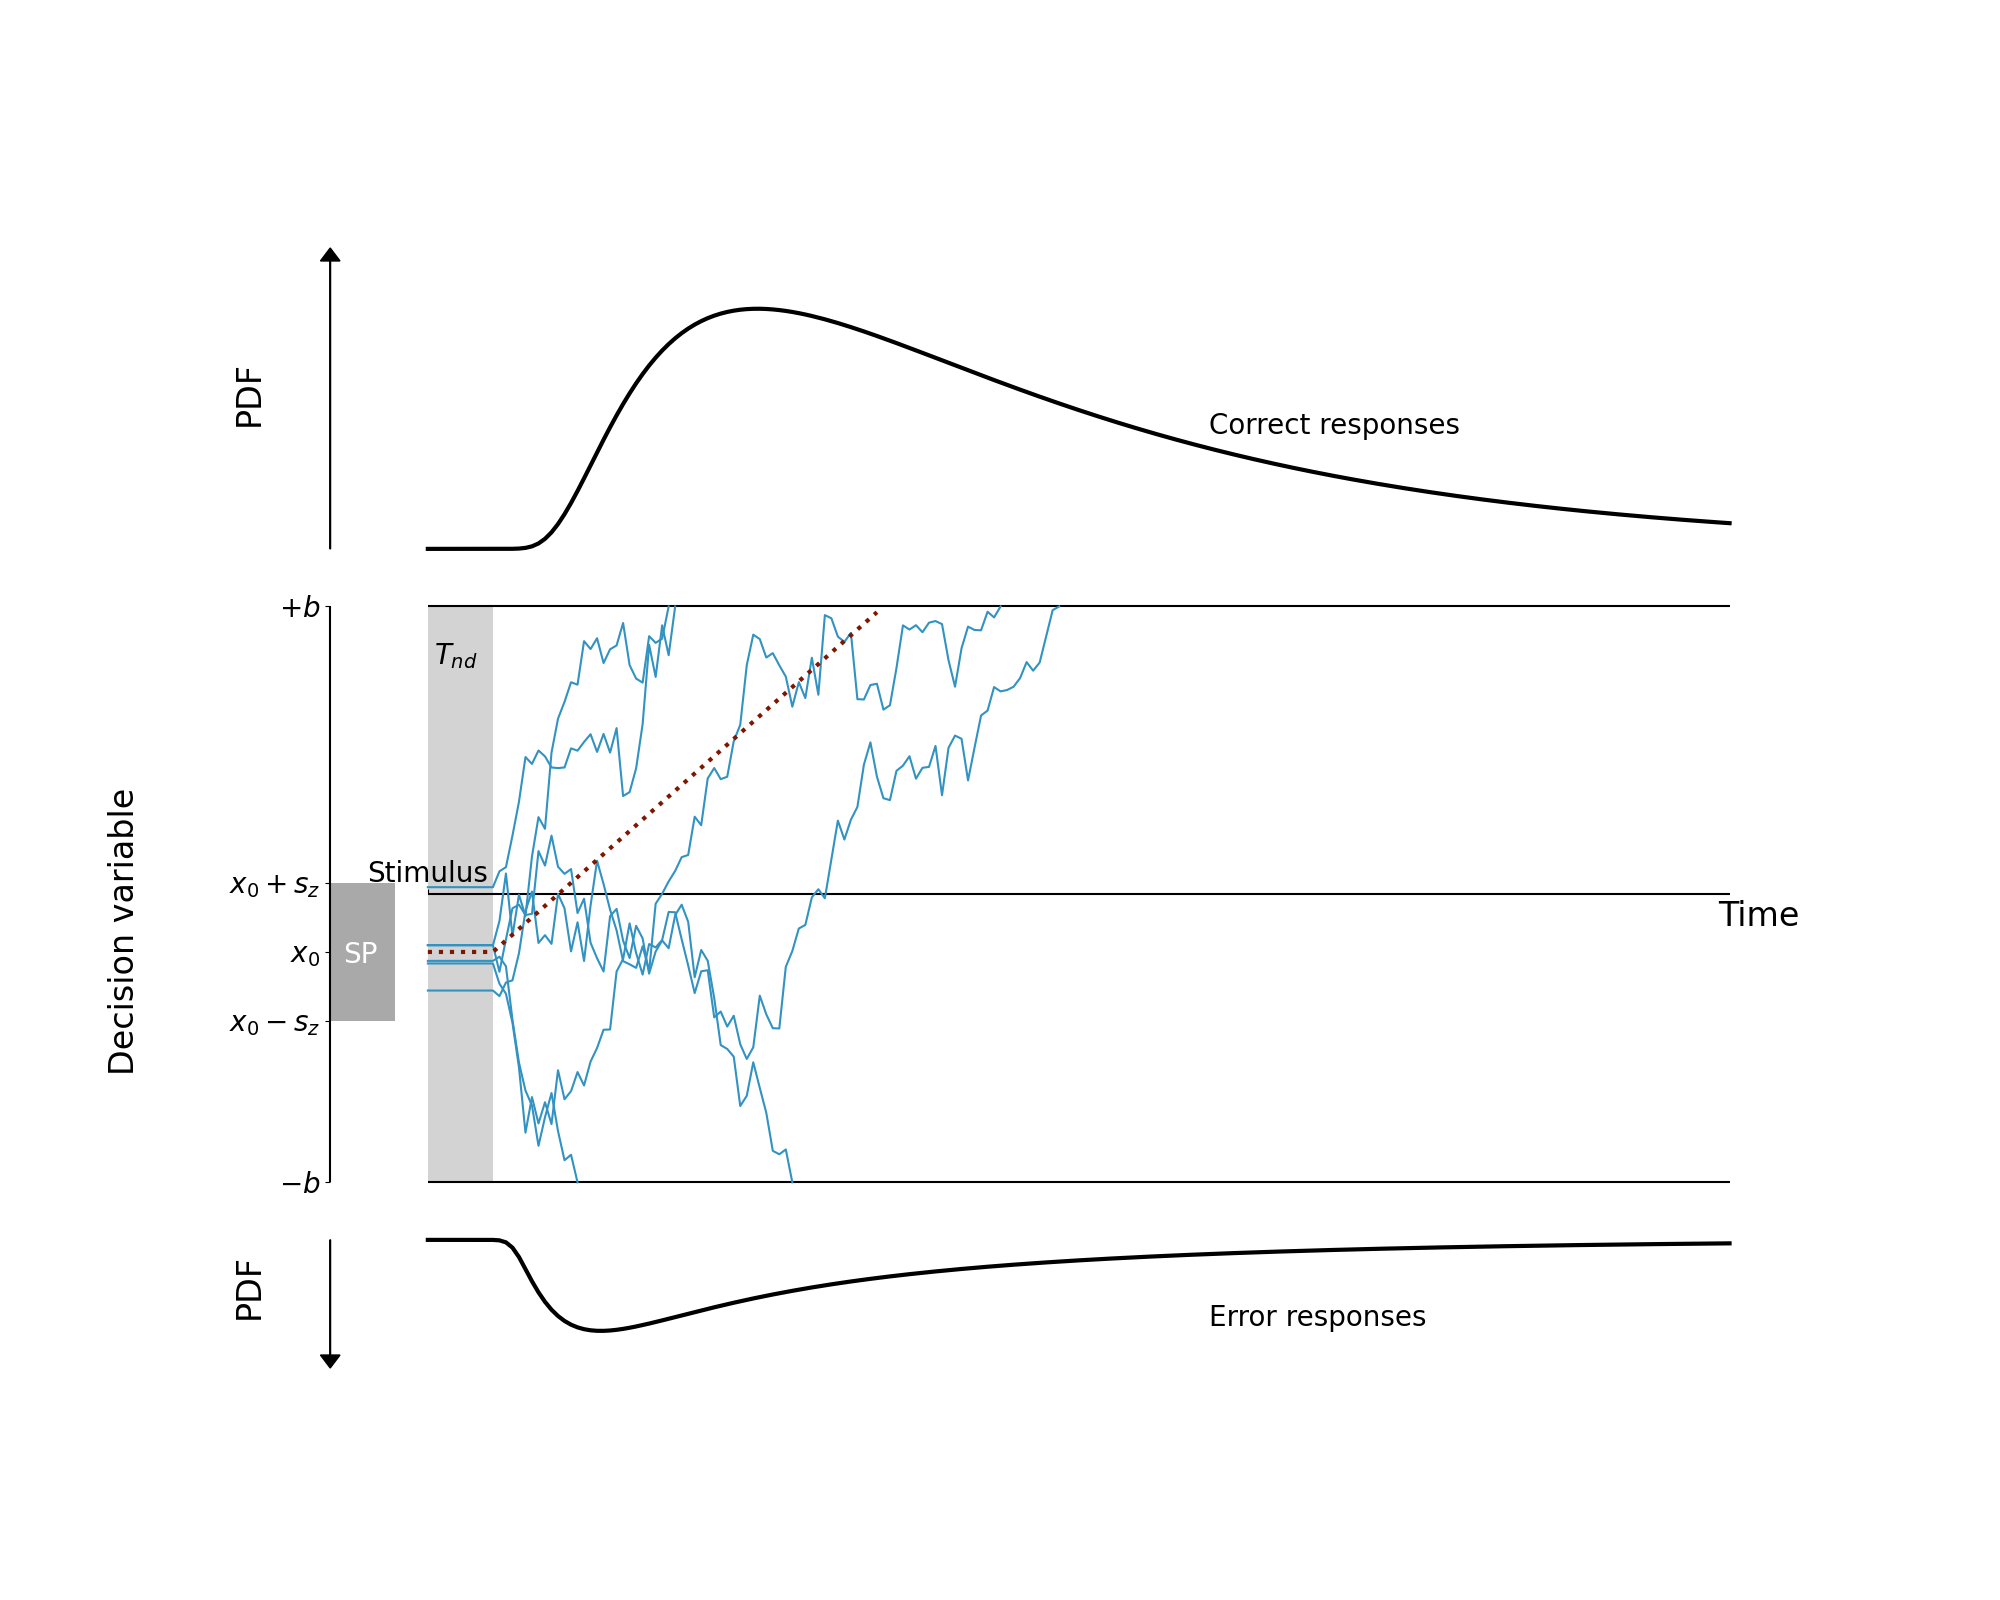

Text(0.01, 0.8, '$T_{nd}$')

In [10]:
'''something that we want to add is a visualization of a trajectory of the ddm, with all nice information.
It may need some modification using inkscape for example, but we basically need the 2 boundaries, the RT distributions, 
the trajectory, an info on the drift, the non-decision time, and the SP distribution.
'''
from ddm import Model
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from ddm.functions import fit_adjust_model, display_model
from ddm import InitialCondition
import seaborn as sns

class ICIntervalRatio(InitialCondition):
    name = "A starting point range expressed as a proportion of the distance between the bounds."
    required_parameters = ["x0","sz"]
    def get_IC(self, x, dx, conditions):
        x0 = self.x0/2 + .5 #rescale to between 0 and 1 (bc we fit x0 w/ vals between -1 and 1)
        shift_i = int((len(x)-1)*x0)
        min_interval_size=min(shift_i,len(x)-shift_i-1) #the interval over which we compute the variation
        sz=int(self.sz*min_interval_size)
        assert shift_i-sz >= 0 and shift_i+sz < len(x), "Invalid initial conditions"
        pdf = np.zeros(len(x))
        pdf[shift_i-sz:shift_i+sz+1] = 1./(2*sz+1) # Initial condition at x=x0*2*B.
        return pdf
    
m = Model(name='Simple model',
              drift=DriftConstant(drift=1.),#previously:2
              noise=NoiseConstant(noise=1.),#previously 1.
              bound=BoundConstant(B=1.),
              IC=ICIntervalRatio(x0=-0.2,sz=0.3),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2)

s = m.solve()

#here we plot the distributions
fig,ax=plt.subplots(figsize=(20,16))

ax.tick_params(axis="x",direction="in", pad=-25)

ax.plot(s.model.t_domain(), s.pdf_corr()+1.2, color='k',linewidth=3) #plot the histogram of correct responses
ax.plot(s.model.t_domain(), -s.pdf_err()-1.2, color='k',linewidth=3)
ax.arrow(-.15, 1.2, 0, 1, color='k',head_width=.03)
ax.arrow(-.15, -1.2, 0, -.4, color="k",head_width=.03)
plt.text(-.30, 1.65, 'PDF',fontsize=24,rotation='vertical')
plt.text(-.3,-1.45,'PDF',fontsize=24,rotation='vertical')

#here generate the middle of what we want
ax.hlines(1,0,2, color='k')
ax.hlines(-1,0,2, color='k')
for i in range (6):
    trial=m.simulate_trial(seed=i)
    trial[trial>1]=1
    trial[trial<-1]=-1
    ax.plot(s.model.t_domain()[0:len(trial)],trial, color='#3292C2')#grey

#here we plot other information (Tnd, drift, SP distribution)
ax.fill_between([0,0,0.1,0.1,0],[-1,1,1,-1,-1],edgecolor=None, facecolor='#D3D3D3')#,alpha=0.2)

perfect_trajectory=np.ones((len(s.model.t_domain()),))
begin_drift=np.min(np.where(s.model.t_domain()>0.1)[0])
perfect_trajectory[0:begin_drift]=-0.2
def draw_line(a,b,x, offset):
    drawn_line=a*(x-offset)+b
    return drawn_line
perfect_trajectory[begin_drift::]=draw_line(2,-0.2,s.model.t_domain(),0.1)[begin_drift::]
ix_end=np.min(np.where(perfect_trajectory>1))
ax.plot(s.model.t_domain()[0:ix_end],perfect_trajectory[0:ix_end],color='#7E1700',linewidth=3.,linestyle="dotted")

sns.despine()
ax.spines['left'].set_position(('data', -0.15))
ax.spines['left'].set_visible(False)
ax.vlines(-0.15,-1,1, color='k')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['bottom'].set_visible(False)
ax.hlines(0,0,2,color='k')

#ax.fill_between([-0.15,-0.15,-0.05,-0.05,-0.15],[-.36,-.03,-.03,-.36,-.36],edgecolor=None, facecolor='#A9A9A9')#,alpha=0.4)
ax.fill_between([-0.15,-0.15,-0.05,-0.05,-0.15],[-.44,.04,.04,-.44,-.44],edgecolor=None, facecolor='#A9A9A9')#,alpha=0.4)
#when it was 0.2: [-0.15,-0.15,-0.05,-0.05,-0.15],[-.36,-.03,-.03,-.36,-.36]

#ax.set_yticks([1,-0.03,-0.2,-.36,-1])
ax.set_yticks([1,.04,-0.2,-.44,-1])
ax.set_yticklabels([r'$+b$',r'$x_0+s_z$',r'$x_0$',r'$x_0-s_z$',r'$-b$'],fontsize=20)
ax.set_xticks([0])
ax.set_xticklabels(['Stimulus'], fontsize=20)

ax.set_ylabel('Decision variable',fontsize=24)
ax.yaxis.set_label_coords(-0.07,0.4)
ax.set_xlabel('Time',fontsize=24,loc='right')

plt.text(1.2, 1.6, 'Correct responses',fontsize=20)
plt.text(1.2,-1.5,'Error responses',fontsize=20)
plt.text(-.13, -.24, 'SP',fontsize=20, color='white')
plt.text(0.01,0.8,r'$T_{nd}$',fontsize=20)

<IPython.core.display.Javascript object>


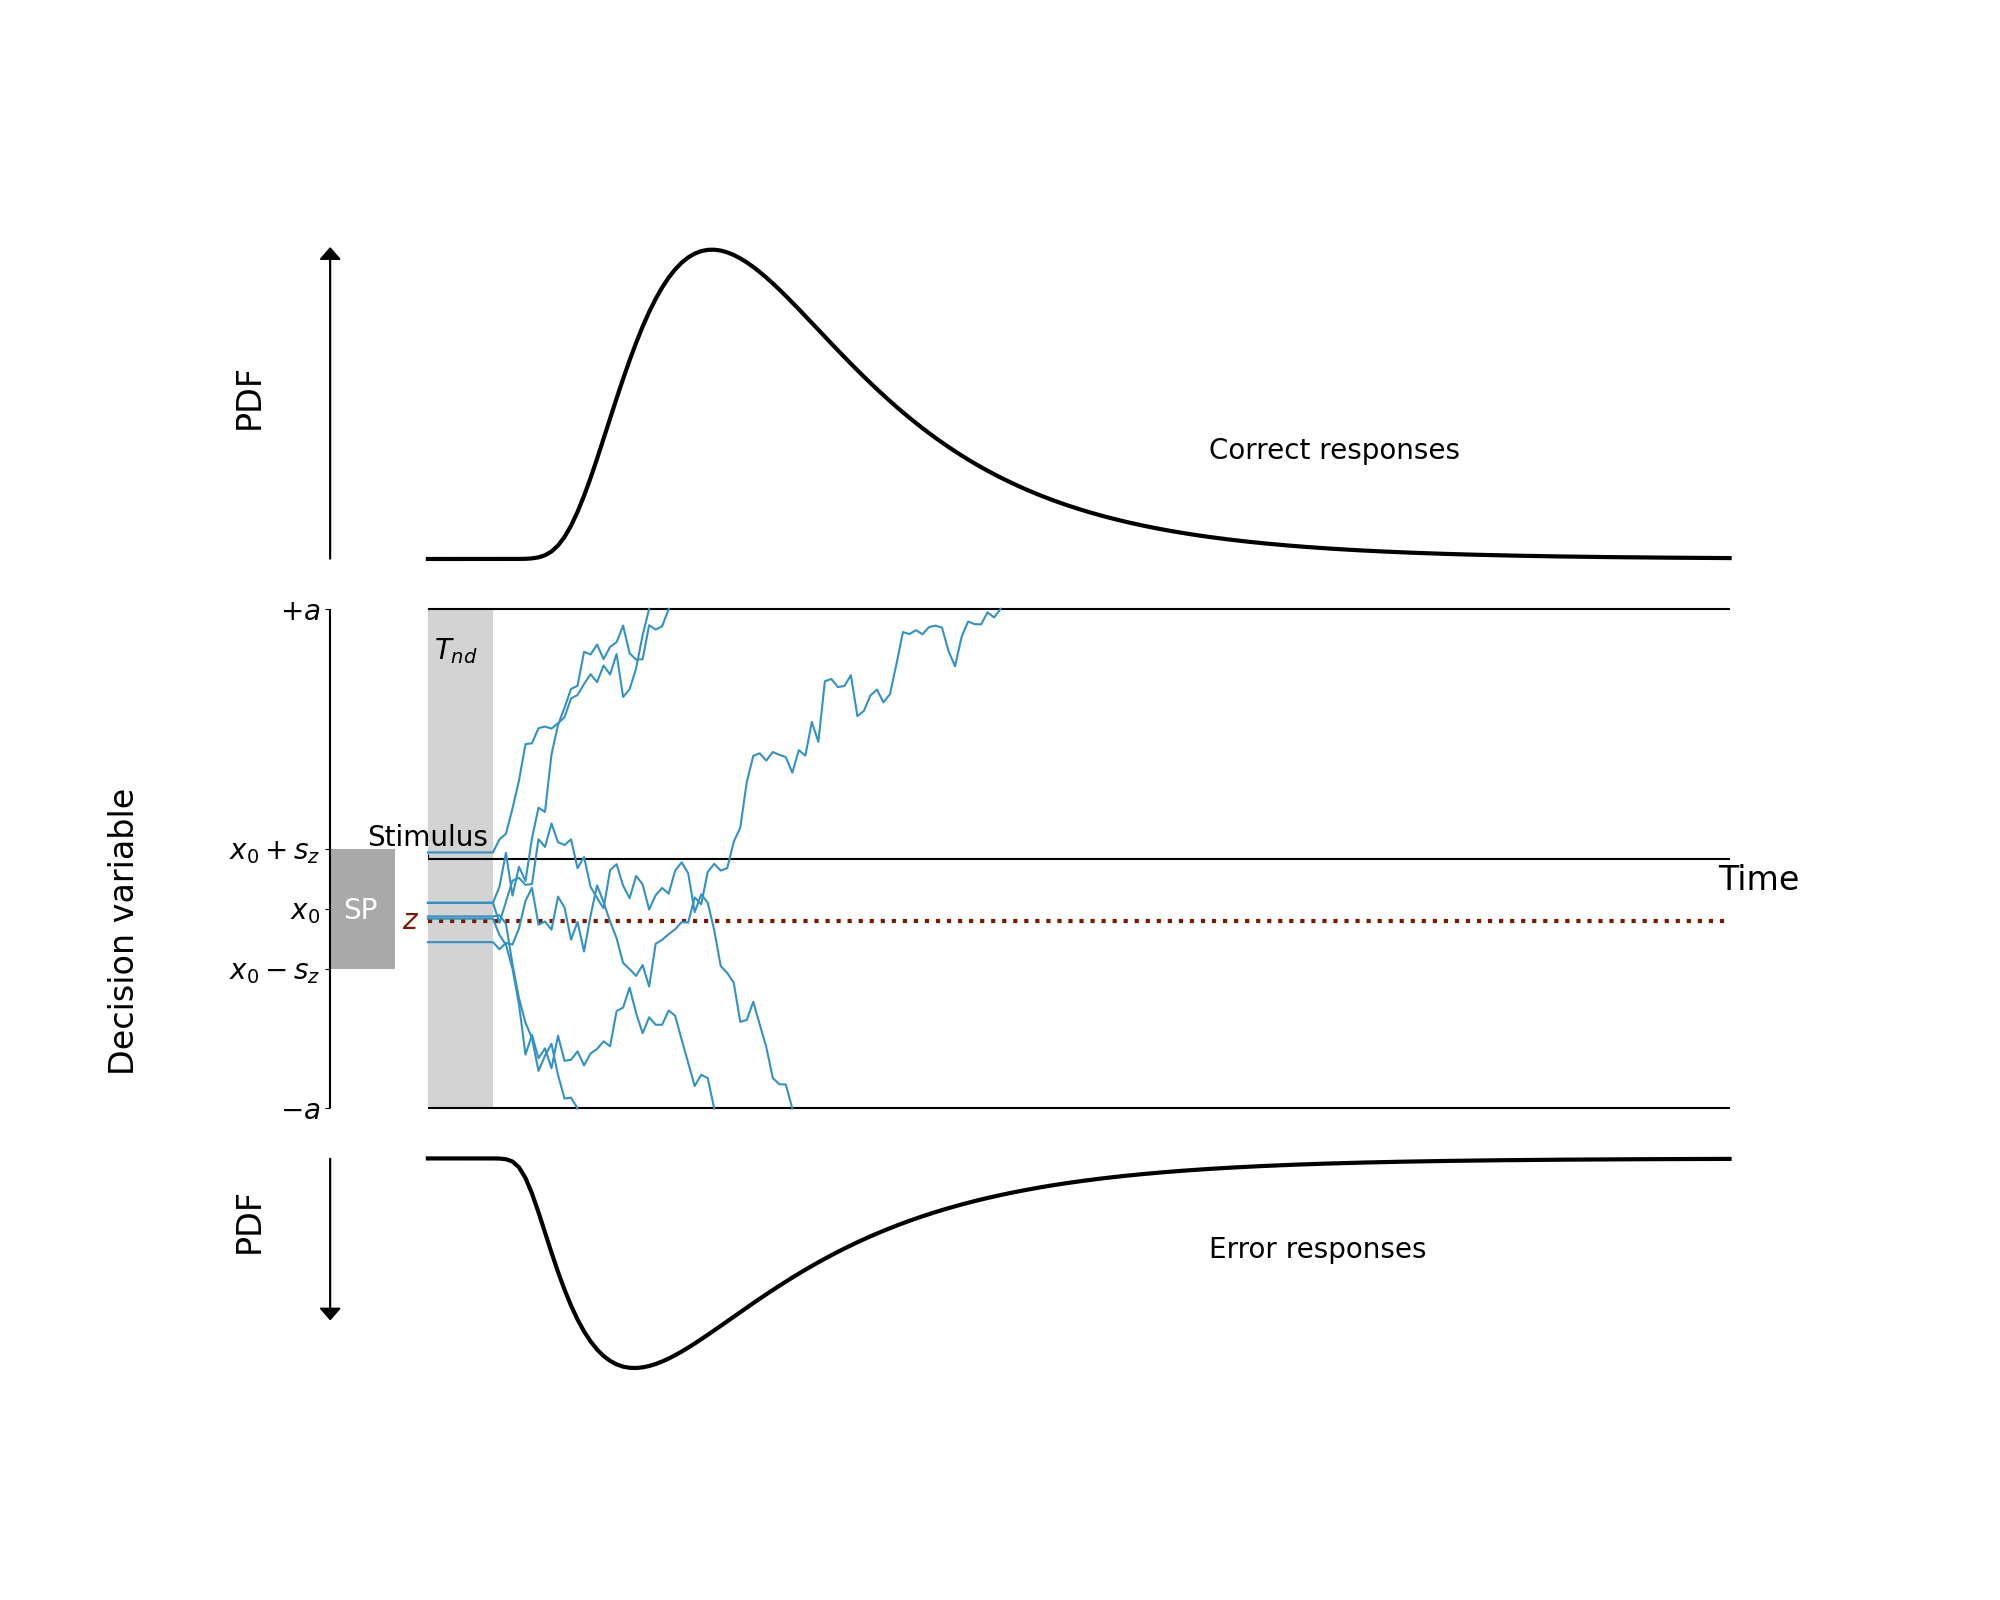

Text(-0.04, -0.28, '$z$')

In [11]:
class ICIntervalRatio(InitialCondition):
    name = "A starting point range expressed as a proportion of the distance between the bounds."
    required_parameters = ["x0","sz"]
    def get_IC(self, x, dx, conditions):
        x0 = self.x0/2 + .5 #rescale to between 0 and 1 (bc we fit x0 w/ vals between -1 and 1)
        shift_i = int((len(x)-1)*x0)
        min_interval_size=min(shift_i,len(x)-shift_i-1) #the interval over which we compute the variation
        sz=int(self.sz*min_interval_size)
        assert shift_i-sz >= 0 and shift_i+sz < len(x), "Invalid initial conditions"
        pdf = np.zeros(len(x))
        pdf[shift_i-sz:shift_i+sz+1] = 1./(2*sz+1) # Initial condition at x=x0*2*B.
        return pdf
    
class ADMunique(Drift):
    name="ADM for mixed conditions"
    required_parameters=["k","z","a"]
    def get_drift(self, x, t, *args,**kwargs):
        return -self.k*(x-self.z*self.a)*(x-self.a)*(x+self.a)
    
m=Model(name="my ADM", drift=ADMunique(k=5.5,a=1,z=-.25), #nice trajectories with z=-.4
            noise=NoiseConstant(noise=.8),#.3
            bound=BoundConstant(B=1), 
            #IC = ddm.models.ic.ICUniform(),
            IC=ICIntervalRatio(x0=-0.2,sz=0.3),
            overlay=OverlayNonDecision(nondectime=.1),
            dx=0.001,
            dt=0.01,#again, a as the bound doesn't work
            T_dur=2.)

s = m.solve()

#here we plot the distributions
fig,ax=plt.subplots(figsize=(20,16))

ax.tick_params(axis="x",direction="in", pad=-25)

ax.plot(s.model.t_domain(), s.pdf_corr()+1.2, color='k',linewidth=3) #plot the histogram of correct responses
ax.plot(s.model.t_domain(), -s.pdf_err()-1.2, color='k',linewidth=3)
ax.arrow(-.15, 1.2, 0, 1.2, color='k',head_width=.03)
ax.arrow(-.15, -1.2, 0, -.6, color="k",head_width=.03)
plt.text(-.30, 1.75, 'PDF',fontsize=24,rotation='vertical')
plt.text(-.3,-1.55,'PDF',fontsize=24,rotation='vertical')

#here generate the middle of what we want
ax.hlines(1,0,2., color='k')
ax.hlines(-1,0,2., color='k')
for i in range (6):
    trial=m.simulate_trial(seed=i)
    trial[trial>1]=1
    trial[trial<-1]=-1
    ax.plot(s.model.t_domain()[0:len(trial)],trial, color='#3292C2')#grey

#here we plot other information (Tnd, drift, SP distribution)
ax.fill_between([0,0,0.1,0.1,0],[-1,1,1,-1,-1],edgecolor=None, facecolor='#D3D3D3')#here this is for Tnd

ax.hlines(-.25,0,2.,color='#7E1700',linewidth=3.,linestyle="dotted")

sns.despine()
ax.spines['left'].set_position(('data', -0.15))
ax.spines['left'].set_visible(False)
ax.vlines(-0.15,-1,1, color='k')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['bottom'].set_visible(False)
ax.hlines(0,0,2.,color='k')

ax.fill_between([-0.15,-0.15,-0.05,-0.05,-0.15],[-.44,.04,.04,-.44,-.44],edgecolor=None, facecolor='#A9A9A9')#,alpha=0.4)
#when it was 0.2: [-0.15,-0.15,-0.05,-0.05,-0.15],[-.36,-.03,-.03,-.36,-.36]

ax.set_yticks([1,.04,-0.2,-.44,-1])
ax.set_yticklabels([r'$+a$',r'$x_0+s_z$',r'$x_0$',r'$x_0-s_z$',r'$-a$'],fontsize=20)
ax.set_xticks([0])
ax.set_xticklabels(['Stimulus'], fontsize=20)

ax.set_ylabel('Decision variable',fontsize=24)
ax.yaxis.set_label_coords(-0.07,0.4)
ax.set_xlabel('Time',fontsize=24,loc='right')

plt.text(1.2, 1.6, 'Correct responses',fontsize=20)
plt.text(1.2,-1.6,'Error responses',fontsize=20)
plt.text(-.13, -.24, 'SP',fontsize=20, color='white')
plt.text(0.01,0.8,r'$T_{nd}$',fontsize=20)

plt.text(-0.04,-.28,r'$z$',color='#7E1700', fontsize=20)